# Simulation Summary

The easiest option should be to splice HNLF to a PM1550 pig tail, and cleave back the HNLF to optimize the spectrum. Once we think we are a few millimeters away, we'll connectorize the HNLF to make a patch cord. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pynlo_peter.Fiber_PPLN_NLSE as fpn
import clipboard_and_style_sheet
import scipy.constants as sc
import scipy.interpolate as spi
import sys
sys.path.append("../")

clipboard_and_style_sheet.style_sheet()

normalize = lambda vec: vec / np.max(abs(vec))


def dBkm_to_m(dBkm):
    km = 10 ** (-dBkm / 10)
    return km * 1e-3


def get_pulse_data(plot=False):
    pulse_data = np.genfromtxt("../210526_2.0W_pulse.txt", skip_header=1)
    T_ps = pulse_data[:, 0]
    intensity_T = pulse_data[:, 1]
    phase_T = pulse_data[:, 2]
    amp_T = np.sqrt(intensity_T)
    AT = amp_T * np.exp(1j * phase_T)

    spec_data = np.genfromtxt("../210526_2.0W_spectrum.txt", skip_header=1)
    wl_nm = spec_data[:, 0]
    intensity_W = spec_data[:, 1]
    phase_W = spec_data[:, 2]
    amp_W = np.sqrt(intensity_W)
    AW = amp_W * np.exp(1j * phase_W)

    # if setting the electric field in the time domain, it's important you
    # have the center frequency defined correctly!
    F_mks = sc.c / (wl_nm * 1e-9)
    func = spi.interp1d(np.linspace(0, 1, len(F_mks)), F_mks)
    center_wavelength_nm = sc.c / func(.5) * 1e9

    # pulse from setting electric field in time domain
    pulse_from_T = fpn.Pulse(time_window_ps=10,
                             center_wavelength_nm=center_wavelength_nm,
                             NPTS=2 ** 14, frep_MHz=100.,
                             EPP_nJ=5.)
    pulse_from_T.set_AT_experiment(T_ps, AT)

    # pulse from setting electric field in frequency domain
    pulse_from_W = fpn.Pulse(time_window_ps=10,
                             center_wavelength_nm=center_wavelength_nm,
                             NPTS=2 ** 14, frep_MHz=100.,
                             EPP_nJ=5.)
    pulse_from_W.set_AW_experiment(wl_nm * 1e-3, AW)

    if plot:
        """verify things were done correctly"""

        # plotting the amplitude
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.plot(pulse_from_T.T_ps, normalize(pulse_from_T.AT.__abs__() ** 2))
        ax1.plot(pulse_from_W.T_ps, normalize(pulse_from_W.AT.__abs__() ** 2))

        ax2.plot(pulse_from_W.F_THz, normalize(pulse_from_W.AW.__abs__() ** 2))
        ax2.plot(pulse_from_T.F_THz, normalize(pulse_from_T.AW.__abs__() ** 2))
        ax2.set_xlim(183, 202)

        # plotting the real
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.plot(pulse_from_T.T_ps, normalize(pulse_from_T.AT.real))
        ax1.plot(pulse_from_W.T_ps, normalize(pulse_from_W.AT.real))

        ax2.plot(pulse_from_W.F_THz, normalize(pulse_from_W.AW.real))
        ax2.plot(pulse_from_T.F_THz, normalize(pulse_from_T.AW.real))
        ax2.set_xlim(183, 202)

        # plotting the imaginary
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.plot(pulse_from_T.T_ps, normalize(pulse_from_T.AT.imag))
        ax1.plot(pulse_from_W.T_ps, normalize(pulse_from_W.AT.imag))

        ax2.plot(pulse_from_W.F_THz, normalize(pulse_from_W.AW.imag))
        ax2.plot(pulse_from_T.F_THz, normalize(pulse_from_T.AW.imag))
        ax2.set_xlim(183, 202)

        """Looks good!"""

    return pulse_from_T, pulse_from_W


pulse_from_T, pulse_from_W = get_pulse_data()


Here is the pulse that Toptica should send us:

Text(0.5, 0, 'ps')

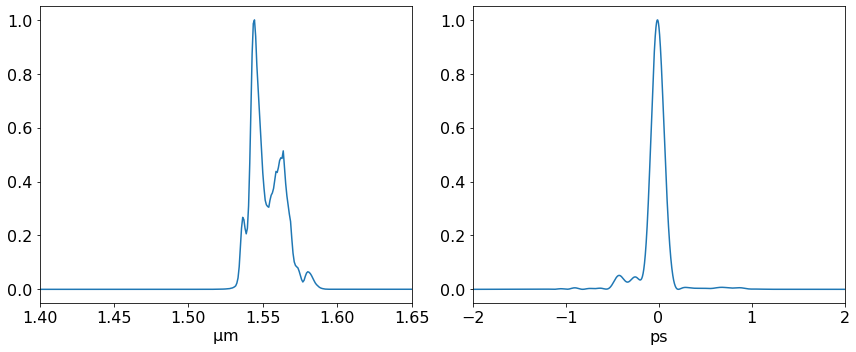

In [2]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ind = (pulse_from_W.wl_nm > 0).nonzero()
ax1.plot(pulse_from_W.wl_um[ind], normalize(pulse_from_W.AW[ind].__abs__()**2))
ax1.set_xlim(1.4, 1.65)
ax1.set_xlabel("$\mathrm{\mu m}$")

ax2.plot(pulse_from_W.T_ps, normalize(pulse_from_W.AT.__abs__()**2))
ax2.set_xlim(-2, 2)
ax2.set_xlabel("ps")

### We would like to get an estimate of what lengths of fiber we need (PM1550 and HNLF). 

The length of HNLF will be different depending on whether we use normal or anomalous dispersion fiber.

### Fiber parameters:

In [3]:
# OFS AD HNLF parameters
adhnlf = {
    "D": 5.4,
    "Dprime": 0.028,
    "gamma": 10.9,
    "Alpha": 0.74,
}

# OFS ND HNLF parameters
ndhnlf = {
    "D": -2.6,
    "Dprime": 0.026,
    "gamma": 10.5,
    "Alpha": 0.8,
}

pm1550 = {
    "D": 18,
    "Dprime": 0.0612,
    "gamma": 1.,
    "Alpha": 0.18
}

In [4]:
fiber_adhnlf = fpn.Fiber()
fiber_adhnlf.generate_fiber(.2,
                            1550.,
                            [adhnlf["D"], adhnlf["Dprime"]],
                            adhnlf["gamma"] * 1e-3,
                            gain=dBkm_to_m(adhnlf["Alpha"]),
                            dispersion_format="D")

fiber_ndhnlf = fpn.Fiber()
fiber_ndhnlf.generate_fiber(.2,
                            1550.,
                            [ndhnlf["D"], ndhnlf["Dprime"]],
                            ndhnlf["gamma"] * 1e-3,
                            gain=dBkm_to_m(ndhnlf["Alpha"]),
                            dispersion_format="D")

fiber_pm1550 = fpn.Fiber()
fiber_pm1550.generate_fiber(.2,
                            1550.,
                            [pm1550["D"], pm1550["Dprime"]],
                            pm1550["gamma"] * 1e-3,
                            gain=dBkm_to_m(pm1550["Alpha"]),
                            dispersion_format="D")


### Simulation for 200MHz 2 W (10nJ Pulse)

In [5]:
# initialize a simulation instance
ssfm = fpn.FiberFourWaveMixing()

# set the pulse energy
pulse_from_W.set_epp(10.e-9)


In [6]:
# go through pm1550 first
fiber_pm1550.length = 0.2
res_pm1550 = ssfm.propagate(pulse_from_W, fiber_pm1550, 100)


Pulse energy before Simple Fiber : 10.0 nJ
pulse energy in  151105.8859142243
copied as   151105.8859142243
Step: 1 Distance remaining: 0.198
Pulse energy after: 9.967106741903581 nJ
Step: 2 Distance remaining: 0.196
Pulse energy after: 9.966615370728528 nJ
Step: 3 Distance remaining: 0.194
Pulse energy after: 9.966092440047955 nJ
Step: 4 Distance remaining: 0.192
Pulse energy after: 9.965536775198649 nJ
Step: 5 Distance remaining: 0.19
Pulse energy after: 9.964946168595375 nJ
Step: 6 Distance remaining: 0.188
Pulse energy after: 9.964318068305198 nJ
Step: 7 Distance remaining: 0.186
Pulse energy after: 9.963649529917673 nJ
Step: 8 Distance remaining: 0.18400000000000002
Pulse energy after: 9.962937163082476 nJ
Step: 9 Distance remaining: 0.18200000000000002
Pulse energy after: 9.962177073546457 nJ
Step: 10 Distance remaining: 0.18000000000000002
Pulse energy after: 9.96136480324929 nJ
Step: 11 Distance remaining: 0.17800000000000002
Pulse energy after: 9.960495271818507 nJ
Step: 12 Di

Pulse energy after: 9.54198176442237 nJ
Step: 99 Distance remaining: 0.0020000000000000018
Pulse energy after: 9.538800268112881 nJ
Pulse energy after Simple Fiber : 9.55760153045659 nJ


In [7]:
# then go through some adhnlf
pulse_out = res_pm1550.pulse
fiber2 = fiber_adhnlf
fiber2.length = .1
res_adhnlf = ssfm.propagate(pulse_out, fiber2, 100)


Pulse energy before Simple Fiber : 9.55760153045659 nJ
pulse energy in  152942.7238656484
copied as   152942.7238656484
Step: 1 Distance remaining: 0.099
Pulse energy after: 9.516628077275312 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 9.492978558739306 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 9.462401274655583 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 9.432883250662982 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 9.400595473968421 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 9.376637940112088 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 9.361446817243293 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 9.350109782829085 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 9.338571436974238 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 9.326986320790489 nJ
Step: 11 Distance remaining: 0.08900000000000001
Pulse energy after: 9.316918179384025 

Pulse energy after: 8.626037614613752 nJ
Step: 97 Distance remaining: 0.0030000000000000027
Pulse energy after: 8.620357765669448 nJ
Step: 98 Distance remaining: 0.0020000000000000018
Pulse energy after: 8.614667652434681 nJ
Step: 99 Distance remaining: 0.0010000000000000009
Pulse energy after: 8.608648412789023 nJ
Pulse energy after Simple Fiber : 8.609803213729911 nJ


Text(0.5, 1.0, 'PM1550 evolution')

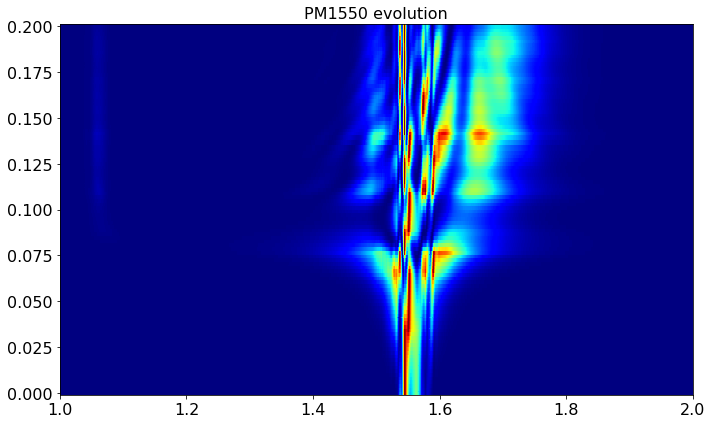

In [8]:
# plot the evolution in pm1550
evolv = fpn.get_2d_evolv(res_pm1550.AW)
plt.figure(figsize=(10, 6))
plt.pcolormesh(pulse_from_W.wl_nm[ind] * 1e-3, res_pm1550.zs, evolv[:, ind][::, 0, ::], shading='auto', cmap='jet')
plt.xlim(1, 2)
plt.title("PM1550 evolution")


Text(0.5, 1.0, 'Subsequent ADHNLF evolution')

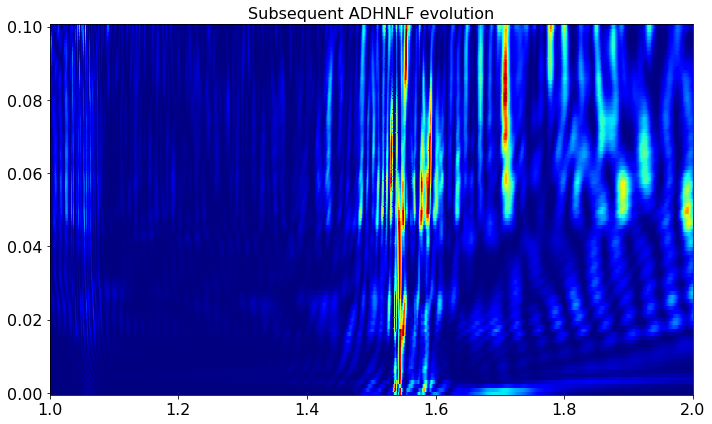

In [9]:
# plot the evolution in adhnlf
evolv = fpn.get_2d_evolv(res_adhnlf.AW)
plt.figure(figsize=(10, 6))
plt.pcolormesh(pulse_from_W.wl_nm[ind] * 1e-3, res_adhnlf.zs, evolv[:, ind][::, 0, ::], shading='auto', cmap='jet')
plt.xlim(1, 2)
plt.title("Subsequent ADHNLF evolution")

In [10]:
# go through some ndhnlf instead after pm1550
pulse_out = res_pm1550.pulse
fiber2 = fiber_ndhnlf
fiber2.length = .2
res_ndhnlf = ssfm.propagate(pulse_out, fiber2, 100)


Pulse energy before Simple Fiber : 9.55760153045659 nJ
pulse energy in  152942.7238656484
copied as   152942.7238656484
Step: 1 Distance remaining: 0.198
Pulse energy after: 9.497032182664297 nJ
Step: 2 Distance remaining: 0.196
Pulse energy after: 9.4576180694739 nJ
Step: 3 Distance remaining: 0.194
Pulse energy after: 9.421709375095677 nJ
Step: 4 Distance remaining: 0.192
Pulse energy after: 9.387914096425256 nJ
Step: 5 Distance remaining: 0.19
Pulse energy after: 9.362598958208077 nJ
Step: 6 Distance remaining: 0.188
Pulse energy after: 9.339106543528402 nJ
Step: 7 Distance remaining: 0.186
Pulse energy after: 9.320346767366152 nJ
Step: 8 Distance remaining: 0.18400000000000002
Pulse energy after: 9.305985730631443 nJ
Step: 9 Distance remaining: 0.18200000000000002
Pulse energy after: 9.296102521526516 nJ
Step: 10 Distance remaining: 0.18000000000000002
Pulse energy after: 9.28782247303011 nJ
Step: 11 Distance remaining: 0.17800000000000002
Pulse energy after: 9.280878223283185 nJ
S

Pulse energy after: 8.918231406935314 nJ
Step: 98 Distance remaining: 0.0040000000000000036
Pulse energy after: 8.915750058674128 nJ
Step: 99 Distance remaining: 0.0020000000000000018
Pulse energy after: 8.913240519087807 nJ
Pulse energy after Simple Fiber : 8.91454706633063 nJ


Text(0.5, 1.0, 'Subsequent NDHNLF evolution')

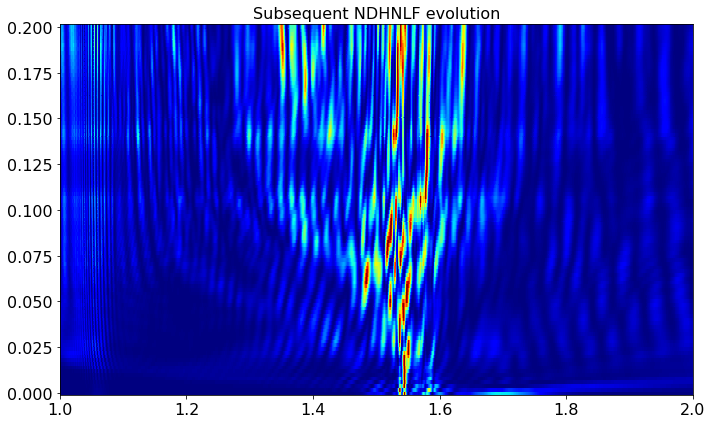

In [11]:
# plot the evolution in ndhnlf
evolv = fpn.get_2d_evolv(res_ndhnlf.AW)
plt.figure(figsize=(10, 6))
plt.pcolormesh(pulse_from_W.wl_nm[ind] * 1e-3, res_ndhnlf.zs, evolv[:, ind][::, 0, ::], shading='auto', cmap='jet')
plt.xlim(1, 2)
plt.title("Subsequent NDHNLF evolution")

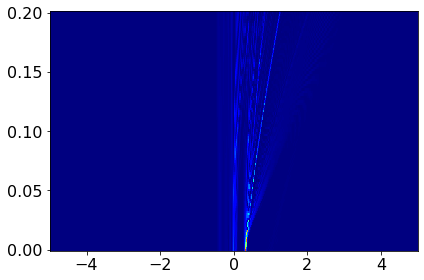

In [12]:
res = res_ndhnlf
plt.pcolormesh(pulse_from_W.T_ps, res.zs, res.AT.__abs__()**2, shading='auto', cmap='jet')

Don't concern yourself with the spectrum once it's obvious the pulse has shredded, it's running out of the simulation's time domain (as evident in the plot above)

It's already shredding inside the pm1550

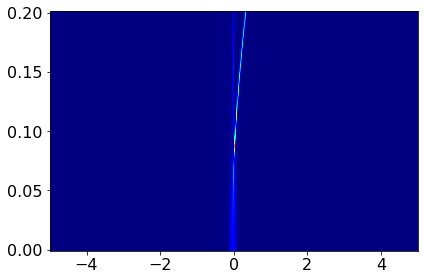

In [13]:
res = res_pm1550
plt.pcolormesh(pulse_from_W.T_ps, res.zs, res.AT.__abs__()**2, shading='auto', cmap='jet')


### Simulation for 100MHz 2 W (20nJ Pulse)

In [14]:
# initialize a simulation instance
ssfm = fpn.FiberFourWaveMixing()

# set the pulse energy
pulse_from_W.set_epp(20.e-9)


In [15]:
# go through pm1550 first
fiber_pm1550.length = 0.2
res_pm1550 = ssfm.propagate(pulse_from_W, fiber_pm1550, 100)


Pulse energy before Simple Fiber : 20.000000000000004 nJ
pulse energy in  213695.9932142976
copied as   213695.9932142976
Step: 1 Distance remaining: 0.198
Pulse energy after: 19.933292313417436 nJ
Step: 2 Distance remaining: 0.196
Pulse energy after: 19.93132751387799 nJ
Step: 3 Distance remaining: 0.194
Pulse energy after: 19.929225529530466 nJ
Step: 4 Distance remaining: 0.192
Pulse energy after: 19.926974472580742 nJ
Step: 5 Distance remaining: 0.19
Pulse energy after: 19.92455617549964 nJ
Step: 6 Distance remaining: 0.188
Pulse energy after: 19.921948267471933 nJ
Step: 7 Distance remaining: 0.186
Pulse energy after: 19.919123083070787 nJ
Step: 8 Distance remaining: 0.18400000000000002
Pulse energy after: 19.916046273007122 nJ
Step: 9 Distance remaining: 0.18200000000000002
Pulse energy after: 19.912675100228444 nJ
Step: 10 Distance remaining: 0.18000000000000002
Pulse energy after: 19.90895637791486 nJ
Step: 11 Distance remaining: 0.17800000000000002
Pulse energy after: 19.9048245

In [16]:
# then go through some adhnlf
pulse_out = res_pm1550.pulse
fiber2 = fiber_adhnlf
fiber2.length = .1
res_adhnlf = ssfm.propagate(pulse_out, fiber2, 100)


Pulse energy before Simple Fiber : 18.60880147277036 nJ
pulse energy in  266083.57200129854
copied as   266083.57200129854
Step: 1 Distance remaining: 0.099
Pulse energy after: 18.54336875286552 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 18.481033757835572 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 18.407477497235835 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 18.348396957155025 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 18.305144643866868 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 18.265192865426236 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 18.227147285272178 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 18.186207876109254 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 18.141973710644777 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 18.09783857391519 nJ
Step: 11 Distance remaining: 0.08900000000000001
Pulse energy after: 18.0592

Pulse energy after: 16.489119275403393 nJ
Step: 96 Distance remaining: 0.0040000000000000036
Pulse energy after: 16.48418915716906 nJ
Step: 97 Distance remaining: 0.0030000000000000027
Pulse energy after: 16.476846117160786 nJ
Step: 98 Distance remaining: 0.0020000000000000018
Pulse energy after: 16.464583454081318 nJ
Step: 99 Distance remaining: 0.0010000000000000009
Pulse energy after: 16.450578488674683 nJ
Pulse energy after Simple Fiber : 16.461537181086438 nJ


Text(0.5, 1.0, 'PM1550 evolution')

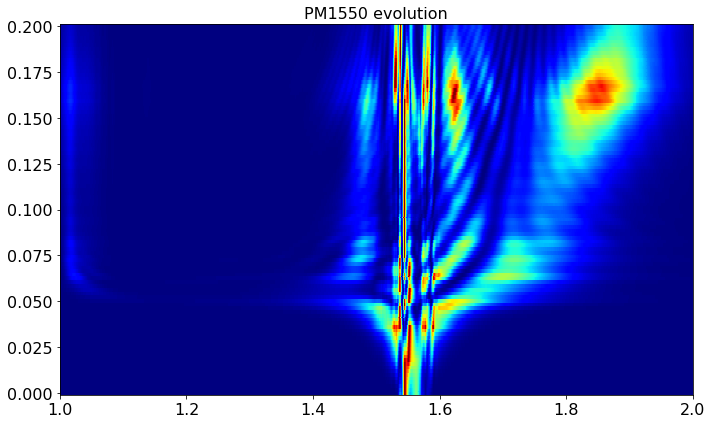

In [17]:
# plot the evolution in pm1550
evolv = fpn.get_2d_evolv(res_pm1550.AW)
plt.figure(figsize=(10, 6))
plt.pcolormesh(pulse_from_W.wl_nm[ind] * 1e-3, res_pm1550.zs, evolv[:, ind][::, 0, ::], shading='auto', cmap='jet')
plt.xlim(1, 2)
plt.title("PM1550 evolution")


Text(0.5, 1.0, 'Subsequent ADHNLF evolution')

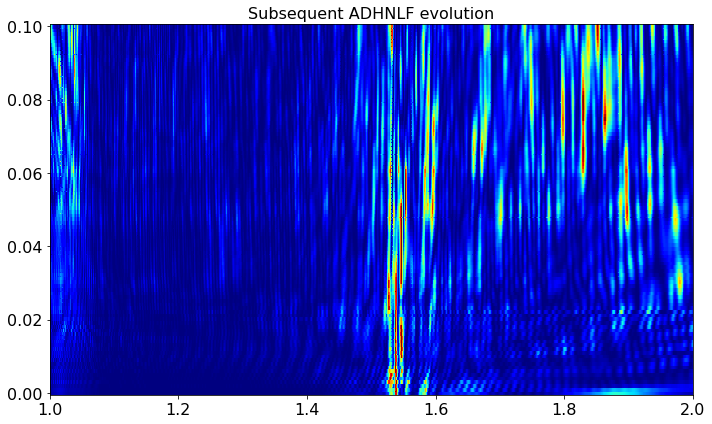

In [18]:
# plot the evolution in adhnlf
evolv = fpn.get_2d_evolv(res_adhnlf.AW)
plt.figure(figsize=(10, 6))
plt.pcolormesh(pulse_from_W.wl_nm[ind] * 1e-3, res_adhnlf.zs, evolv[:, ind][::, 0, ::], shading='auto', cmap='jet')
plt.xlim(1, 2)
plt.title("Subsequent ADHNLF evolution")

In [19]:
# go through some ndhnlf instead after pm1550
pulse_out = res_pm1550.pulse
fiber2 = fiber_ndhnlf
fiber2.length = .2
res_ndhnlf = ssfm.propagate(pulse_out, fiber2, 100)


Pulse energy before Simple Fiber : 18.60880147277036 nJ
pulse energy in  266083.57200129854
copied as   266083.57200129854
Step: 1 Distance remaining: 0.198
Pulse energy after: 18.49586127555333 nJ
Step: 2 Distance remaining: 0.196
Pulse energy after: 18.386042993006456 nJ
Step: 3 Distance remaining: 0.194
Pulse energy after: 18.297807679660078 nJ
Step: 4 Distance remaining: 0.192
Pulse energy after: 18.222278237154153 nJ
Step: 5 Distance remaining: 0.19
Pulse energy after: 18.16362674941926 nJ
Step: 6 Distance remaining: 0.188
Pulse energy after: 18.108180276171865 nJ
Step: 7 Distance remaining: 0.186
Pulse energy after: 18.05898513733947 nJ
Step: 8 Distance remaining: 0.18400000000000002
Pulse energy after: 18.00665887120776 nJ
Step: 9 Distance remaining: 0.18200000000000002
Pulse energy after: 17.94961990182002 nJ
Step: 10 Distance remaining: 0.18000000000000002
Pulse energy after: 17.899390008439436 nJ
Step: 11 Distance remaining: 0.17800000000000002
Pulse energy after: 17.85753444

Pulse energy after: 16.775695576362786 nJ
Step: 96 Distance remaining: 0.008000000000000007
Pulse energy after: 16.768467600383868 nJ
Step: 97 Distance remaining: 0.006000000000000005
Pulse energy after: 16.761131912246555 nJ
Step: 98 Distance remaining: 0.0040000000000000036
Pulse energy after: 16.753624025390444 nJ
Step: 99 Distance remaining: 0.0020000000000000018
Pulse energy after: 16.74603887344632 nJ
Pulse energy after Simple Fiber : 16.746603620429376 nJ


Text(0.5, 1.0, 'Subsequent NDHNLF evolution')

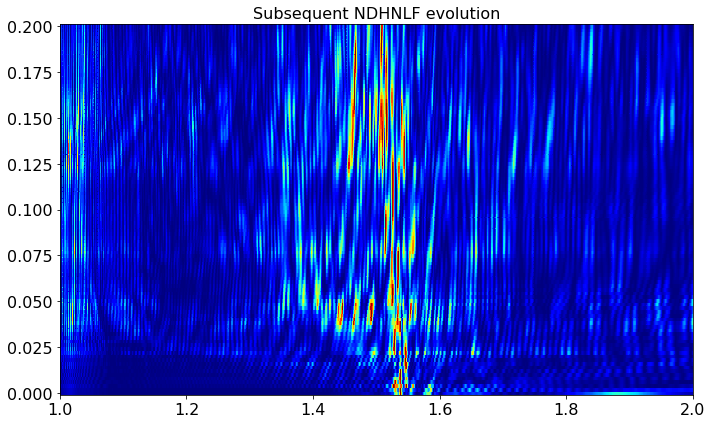

In [20]:
# plot the evolution in ndhnlf
evolv = fpn.get_2d_evolv(res_ndhnlf.AW)
plt.figure(figsize=(10, 6))
plt.pcolormesh(pulse_from_W.wl_nm[ind] * 1e-3, res_ndhnlf.zs, evolv[:, ind][::, 0, ::], shading='auto', cmap='jet')
plt.xlim(1, 2)
plt.title("Subsequent NDHNLF evolution")

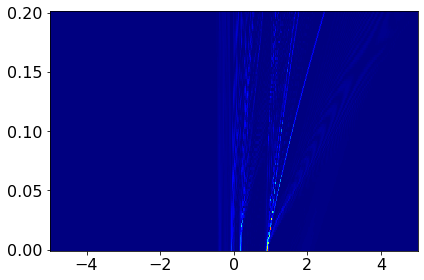

In [21]:
res = res_ndhnlf
plt.pcolormesh(pulse_from_W.T_ps, res.zs, res.AT.__abs__()**2, shading='auto', cmap='jet')

Don't concern yourself with the spectrum once it's obvious the pulse has shredded, it's running out of the simulation's time domain (as evident in the plot above)

It's already shredding inside the pm1550

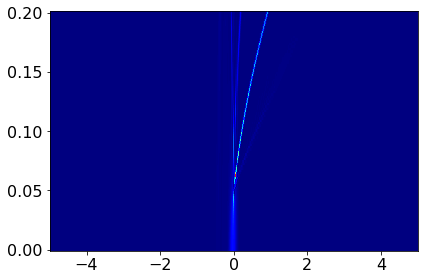

In [22]:
res = res_pm1550
plt.pcolormesh(pulse_from_W.T_ps, res.zs, res.AT.__abs__()**2, shading='auto', cmap='jet')


# What happens if you go to HNLF directly?